# Install requirements

In [ ]:
!pip install gdown
# !pip install spacy
!python -m spacy download it_core_news_sm
!pip install nltk
!pip install gensim
# !pip install stanza


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 28.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Import and download files

In [ ]:

import gdown
import torch
import spacy
import random
from tqdm import tqdm
import re
from pathlib import Path
from collections import Counter
import json
import gensim
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, vocab
from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.metrics import precision_score,recall_score,f1_score


seed = 58
torch.manual_seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(42)

In [ ]:
#loads the file needed
# same as the above, and you can copy-and-paste a URL from Google Drive with fuzzy=True
url_train = "https://drive.google.com/file/d/1ZkVSf4Pc8I-bQegCto8R4a1X9x-8psAo/view?usp=sharing"
output_train = '/content/haspeede3-task1-train-data.jsonl'
gdown.download(url=url_train, output=output_train, fuzzy=True)

url_test = 'https://drive.google.com/file/d/1mGgGAmxyF_6JKvGnY-9w0b28Ug04vzgt/view?usp=sharing'
output_test ='/content/haspeede3-task1-test-data.jsonl'

gdown.download(url=url_test, output=output_test, fuzzy=True)


Downloading...
From: https://drive.google.com/uc?id=1ZkVSf4Pc8I-bQegCto8R4a1X9x-8psAo
To: /content/haspeede3-task1-train-data.jsonl
100%|██████████| 1.66M/1.66M [00:00<00:00, 109MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mGgGAmxyF_6JKvGnY-9w0b28Ug04vzgt
To: /content/haspeede3-task1-test-data.jsonl
100%|██████████| 1.30M/1.30M [00:00<00:00, 101MB/s]


'/content/haspeede3-task1-test-data.jsonl'

# Utilities

In [ ]:


#Test: create a vocabulary
# def tokenize_italian(texts_tuple,stopwords=True):
#     nlp = spacy.load("it_core_news_sm")
#     results= []
#     italian_stopwords = nlp.Defaults.stop_words if stopwords else set()
#     for elem in texts_tuple:
#         text_tokenized = [token.text for token in nlp(elem[0]) if token not in italian_stopwords ]
#         results.append((text_tokenized,elem[1]))
#     return results




def clean_tweet(tweet):
    # Remove @ but keep the username
    tweet = re.sub(r'@(\w+)', r'\1', tweet)
    # Remove # but keep the hashtag text
    tweet = re.sub(r'#(\w+)', r'\1', tweet)
    # Remove URLs and placeholder [URL]
    tweet = re.sub(r'http\S+|www\S+|\[URL\]', '', tweet)
    # Optionally remove special characters or anything else unnecessary
    # tweet = re.sub(r'[^\w\s]', '', tweet)
    # Remove extra spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

# Example usage
tweets = ["Check out @username and #hashtag. [URL]", "Amazing photo by @user in #exciting [URL]"]
cleaned_tweets = [clean_tweet(tweet) for tweet in tweets]
print(cleaned_tweets)



def tokenize_italian_text(text,nlp,type_tokenizer,italian_stopwords=set()):
    if type_tokenizer == "spacy":
        text_tokenized = [token.text.lower() for token in nlp(text) if token.text.lower() not in italian_stopwords ]
        return text_tokenized
    elif type_tokenizer == "nltk":
        tokens = nlp.tokenize(text)
        tokens = [token.lower() for token in tokens if token.lower() not in italian_stopwords]
        return tokens
    elif type_tokenizer == "stanza":
        doc = nlp(text)
        text_tokenized = [word.text.lower() for sentence in doc.sentences for word in sentence.words if word.text.lower() not in italian_stopwords]
        return text_tokenized
    else:
        raise Exception("Error: tokenizer not recognized")
        return None





import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer



def create_data(json_data, augmentation=False,tokenizer='nltk', stop_w=True):
    data = []
    #TOKENIZER CHOICE
    if tokenizer == 'spacy':
        nlp = spacy.load("it_core_news_sm") #TODO forse questo mi rallenta, pensaci!
        italian_stopwords = spacy.lang.it.stop_words.STOP_WORDS
    elif tokenizer == 'nltk':
        nltk.download('stopwords')
        italian_stopwords = stopwords.words('italian')
    nlp_nltk = WordPunctTokenizer()
    if not stop_w:
        italian_stopwords = set()
    for i, element in enumerate(tqdm(json_data)):
        sample = dict()
        if augmentation:
            sample1 = dict()
            sample2 = dict()
        text = element['text']
        text = clean_tweet(text)
        idx = int(element['id'].split('_')[-1])
        choices = element['choices']
        index_label = int(element['label'])
        label = choices[index_label]
        label = 0 if (label=='neutrale') else 1
        sample["text"] = text
        sample["idx"] = idx
        # tokens = [token.text for token in nlp(text) if token.text.lower() not in italian_stopwords] # tokens spacy
        tokens = tokenize_italian_text(text,nlp_nltk,"nltk",italian_stopwords) # tokens nltk
        # if i == 100: break
        if augmentation:
            tokens1 = tokens
            tokens2 = tokens
            sample["label"] = label
            sample["tokens"] = tokens
            random.shuffle(tokens1)
            sample1["tokens"] = tokens1
            sample1["label"] = label
            random.shuffle(tokens2)
            sample2["tokens"] = tokens2
            sample2["label"] = label
            data.append(sample)
            data.append(sample1)
            data.append(sample2)
        else:
            # sample["tokens"] = [token.text for token in nlp(text) if token.text.lower() not in italian_stopwords ] # tokens spacy
            sample["tokens"] = tokenize_italian_text(text,nlp_nltk,"nltk",italian_stopwords) # tokens nltk
            sample["label"] = label
            data.append(sample)
    return data












['Check out username and hashtag.', 'Amazing photo by user in exciting']


In [ ]:

data = []
with open("haspeede3-task1-train-data.jsonl", 'r', encoding='utf-8') as f:
    for line in f:
        sample = json.loads(line)
        data.append(sample)
# Now the 'data' list contains the data from the .jsonl file

random.shuffle(data)
split_index = int(0.80 * len(data))
train_part = data[:split_index]
validation_part = data[split_index:]


test_part = []
with open("haspeede3-task1-test-data.jsonl", 'r', encoding='utf-8') as f:
    for line in f:
        sample = json.loads(line)
        test_part.append(sample)


train_data = create_data(train_part,stop_w=True)
validation_data = create_data(validation_part,stop_w=True)
test_data = create_data(test_part,stop_w=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
100%|██████████| 4480/4480 [00:01<00:00, 2260.71it/s]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 1120/1120 [00:00<00:00, 2220.96it/s]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 4400/4400 [00:02<00:00, 1863.65it/s]


In [ ]:
data[0]

{'id': 'haspeede3_train_5081',
 'text': '@571709376253630 Nurses stile Minetti ai bunga bunga parties di #Berlusconi o al S Raffaele ora 😉🤣🤣🤣',
 'choices': ["incitamento all'odio", 'neutrale'],
 'label': 1}

In [ ]:
train_data[0]

{'text': '571709376253630 Nurses stile Minetti ai bunga bunga parties di Berlusconi o al S Raffaele ora 😉🤣🤣🤣',
 'idx': 5081,
 'tokens': ['571709376253630',
  'nurses',
  'stile',
  'minetti',
  'bunga',
  'bunga',
  'parties',
  'berlusconi',
  's',
  'raffaele',
  'ora',
  '😉🤣🤣🤣'],
 'label': 0}

In [ ]:
# DIFFERENCE FROM STOPWORDS AND NOT
# train_data_NOSTOP = create_data(train_part,stop_w=False)
# train_data_STOP = create_data(train_part,stop_w=True)
# print(train_data_STOP[2]["tokens"])
# print(train_data_NOSTOP[2]["tokens"])



# Tests

In [ ]:
#TEST ALL TOKENIZER
#FIRST TEST


# # dataset_base = Haspeede3('haspeede3-task1-train-PART.jsonl')
# text_1 = train_data[3]["text"]
# print(text_1)
# text_1 = clean_tweet(text_1)
# print(text_1)




# #TOKENIZER 1 SPACY
# nlp_spacy = spacy.load("it_core_news_sm") #TODO forse questo mi rallenta, pensaci!
# stop_words_spacy = spacy.lang.it.stop_words.STOP_WORDS
# tokens_1_spacy = tokenize_italian_text(text_1,nlp_spacy,"spacy",stop_words_spacy)
# print(tokens_1_spacy)


# #TOKENIZER 2 NLTK
# # import nltk
# # from nltk.corpus import stopwords
# # from nltk.tokenize import WordPunctTokenizer

# # nltk.download('stopwords')
# stop_words_nltk = stopwords.words('italian')
# nlp_nltk = WordPunctTokenizer()
# tokens_1_nltk = tokenize_italian_text(text_1,nlp_nltk,"nltk",stop_words_nltk)


# # #TOKENIZER 3 STANZA
# # import stanza
# # stanza.download('it')
# nlp_stanza = stanza.Pipeline('it')
# stop_words_stanza = stop_words_spacy
# tokens_1_stanza = tokenize_italian_text(text_1,nlp_stanza,"stanza",stop_words_stanza)

# print(tokens_1_spacy)
# print(tokens_1_nltk)
# print(tokens_1_stanza)


# t1 = tokenize_italian_text(text_1,nlp)
# t2 = tokenize_italian_text_2(text_1,nlp_stanza)
# t3 = tokenize_italian_text_3(text_1,tokenizer)

# print(t1)
# print(t2)
# print(t3)


# Dataset model and train class setup


In [ ]:
class Haspeede3(Dataset):
    def __init__(self, data, max_length: int = 1028,augmentation:bool = False,device: str = "cuda"):
        self.data = data
        self.padding_id: int | None = None
        self.indexed_data: list[dict] | None = None
        # Keep track of the maximum length to allow for a batch
        self.max_length = max_length
        # Save device
        self.device = torch.device(device)


    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> dict:
        return self.data[idx]["tokens"],self.data[idx]["label"]

    def get_data(self,idx:int) -> dict:
        if idx < len(self.data):
            return self.data[idx]


    def set_padding_id(self,value:int) -> None:
        self.padding_id = value

    def get_raw_padding_id(self):
        return self.padding_id

    def set_model(self,model):
        self.model = model

    def _collate_fn(self, raw_batch: list[dict]) -> tuple[torch.Tensor,torch.Tensor,torch.Tensor]:
        if self.padding_id is None:
            raise RuntimeError("Error: padding not set! Use set_padding_id method!")

        sentences = [s[0] for s in raw_batch]
        labels = [l[1] for l in raw_batch]

        sentences_embedded = []
        for sentence in sentences:
            sentence_embedded = []
            for idx,word in enumerate(sentence):
                if word not in self.model.wv:
                    embedding = self.model.wv["<unk>"]
                else:
                    embedding = self.model.wv[word]
                sentence_embedded.append(embedding.tolist())
            sentences_embedded.append(sentence_embedded)


        # print(f"eccolo -> {sentences_embedded}")
        sequence_lengths = torch.tensor([len(sample) for sample in sentences], dtype=torch.long)

        padded_sequence = pad_sequence(
            (
                torch.tensor(sentence,dtype = torch.float32, device = self.device)
                for sentence in sentences_embedded
            ),
            batch_first = True,
            padding_value = self.padding_id
        )
        labels = torch.tensor(labels, device = self.device, dtype=torch.long)
        return sequence_lengths,padded_sequence,labels

In [ ]:
class BiLSTMModel(torch.nn.Module):

    def __init__(
        self,
        # vocabulary_length: int,
        hidden_dim: int,
        input_size: int, #dim of w2v
        bilstm_layers: int,
        bilstm_dropout: float,
        num_classes: int,
        padding_id: int,
        bidirectional: bool,
        # embedding_matrix: Tensor,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        # Prepare the device
        self.device = torch.device(device)

        # Embedding layer
        # self.embedding = nn.Embedding(
        #     num_embeddings=vocabulary_length,
        #     embedding_dim=hidden_dim,
        #     padding_idx=padding_id, # avoid updating the gradient of padding entries
        #     device=self.device
        # )

        self.bid = bidirectional
        # BiLSTM
        self.bilstm = nn.LSTM(
            # input_size=hidden_dim,
            input_size=input_size,
            hidden_size=hidden_dim,
            num_layers=bilstm_layers,
            batch_first=True,
            dropout=bilstm_dropout,
            bidirectional=self.bid,
            device=self.device
        )


        multiplicative_term = 2 if self.bid else 1

        #TEST
        # self.fc1 = nn.Linear(hidden_dim,64,device=self.device)
        # self.fc2 = nn.Linear(64,hidden_dim * multiplicative_term,device=self.device)

        # # Projection layer
        # multiplicative_term = 2 if self.bid else 1
        # self.projection = nn.Linear(
        #     in_features=hidden_dim * multiplicative_term,
        #     out_features=num_classes,
        #     device=device
        # )

        # Projection layer
        self.projection = nn.Linear(
            in_features=hidden_dim * multiplicative_term,
            out_features=num_classes,
            device=device
        )

    def forward(self, batch) -> torch.Tensor:
        sequence_lengths,tokens = batch
        # Pack the sequence to avoid gradient descent on padding tokens.
        packed = pack_padded_sequence(tokens, sequence_lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden_state, cell_state) = self.bilstm(packed)
        if self.bid==True:
            # print("1=bidirectional lstm mode")
            # We take the last two hidden representations of the BiLSTM (the second-to-last layer's output is forward; last
            # layer's is backward) by concatenating forward and backward over dimension 1.
            # Both tensors have shapes of [B, H], so concatenating them along the second dimension (dim 1) results in a new
            # tensor of shape [B, 2 * H]
            hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        else:
            # print("1 lstm mode")
            hidden = hidden_state[-1,:,:]


        # Finally we project to the two final classes and return the logits of each class
        logits = self.projection(hidden) # [B, 1}?
        return logits


In [ ]:
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        log_steps: int = 1_000,
        log_level: int = 2
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = nn.CrossEntropyLoss()
        self.log_steps = log_steps
        self.log_level = log_level

    def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1
    ) -> dict[str, list[float]]:
        """
        Args:
            train_dataloader: a DataLoader instance containing the training instances.
            valid_dataloader: a DataLoader instance used to evaluate learning progress.
            epochs: the number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over epochs.
        """
        assert epochs >= 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')

        train_loss = 0.0

        losses = {
            "train_losses": [],
            "valid_losses": [],
            "valid_acc": [],
            "valid_prec": [],
        }

        best_value = 0
        for epoch in range(1, epochs + 1):
            if self.log_level > 0:
                print(' Epoch {:2d}'.format(epoch))
            epoch_loss = 0.0
            self.model.train()
            # for each batch
            for step, (sequence_lengths, inputs, labels) in enumerate(train_dataloader):
                self.optimizer.zero_grad()
                # We get the predicted logits from the model, with no need to perform any flattening
                # as both predictions and labels refer to the whole sentence.
                predictions = self.model((sequence_lengths, inputs))
                # Adjust labels to be the correct shape (B, 1)
                # labels = labels.float().unsqueeze(1)
                # The CrossEntropyLoss expects the predictions to be logits, i.e. non-softmaxed scores across
                # the number of classes, and the labels to be a simple tensor of labels.
                # Specifically, predictions needs to be of shape [B, C], where B is the batch size and C is the number of
                # classes, while labels must be of shape [B] where each element l_i should 0 <= l_i < C.
                # See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for more information.
                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()
                epoch_loss += sample_loss.cpu().tolist()
                if self.log_level > 1 and (step % self.log_steps) == (self.log_steps - 1):
                    print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))

            avg_epoch_loss = epoch_loss / len(train_dataloader)

            if self.log_level > 0:
                print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss, valid_acc,valid_prec = self.evaluate(valid_dataloader)


            if valid_acc > best_value:
              best_value = valid_acc
              torch.save(self.model,'best_model.pth')

            losses["train_losses"].append(avg_epoch_loss)
            losses["valid_losses"].append(valid_loss)
            losses["valid_acc"].append(valid_acc)
            losses["valid_prec"].append(valid_prec)

            if self.log_level > 0:
                print('  [E: {:2d}] valid loss = {:0.4f}, valid acc = {:0.4f}'.format(epoch, valid_loss, valid_acc))

        if self.log_level > 0:
            print('... Done!')

        return losses





    def _compute_precision(self, logits: torch.Tensor, labels: torch.Tensor):
        predictions = torch.argmax(logits, dim=1)  # Assumes logits is [batch_size, num_classes]
        TP = torch.sum((predictions == 1) & (labels == 1))  # True Positives
        FP = torch.sum((predictions == 1) & (labels == 0))  # False Positives

        # Avoid division by zero by adding a small epsilon where denominator is zero
        epsilon = 1e-8
        return (TP.float() / (TP + FP + epsilon).float()).item()





    def _compute_acc(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        # logits [B, 2] are the logits outputted by the BiLSTM model's forward()
        # We take the argmax along the second dimension (dim=1), so we get a tensor of shape [B]
        # where each element is 0 if the 0-class had higher logit, 1 otherwise.
        predictions = torch.argmax(logits, dim=1)
        # We can then directly compare each prediction with the labels, as they are both tensors with shape [B].
        # The average of the boolean equality checks between the two is the accuracy of these predictions.
        # For example, if:
        #   predictions = [1, 0, 0, 1, 1]
        #   labels = [1, 0, 1, 1, 1]
        # The comparison is:
        #   (predictions == labels) => [1, 1, 0, 1, 1]
        # which averaged gives an accuracy of 4/5, i.e. 0.80.
        return torch.mean((predictions == labels).float()).tolist() # type: ignore

    def evaluate(self, valid_dataloader: DataLoader) -> tuple[float, float]:
        """
        Args:
            valid_dataloader: the DataLoader to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over valid_dataloader.
        """
        valid_loss = 0.0
        valid_acc = 0.0
        valid_prec = 0.0
        # When running in inference mode, it is required to have model.eval() AND .no_grad()
        # Among other things, these set dropout to 0 and turn off gradient computation.
        self.model.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                sequence_lengths, inputs, labels = batch
                logits = self.model((sequence_lengths, inputs))
                # Adjust labels to be the correct shape also here (B, 1)
                # labels = labels.float().unsqueeze(1)
                # Same considerations as the training step apply here
                sample_loss = self.loss_function(logits, labels)
                valid_loss += sample_loss.tolist()
                sample_acc = self._compute_acc(logits, labels)
                precision_ = self._compute_precision(logits,labels)
                valid_acc += sample_acc
                valid_prec += precision_

        return valid_loss / len(valid_dataloader), valid_acc / len(valid_dataloader),valid_prec/len(valid_dataloader)

    def predict(self, batch: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: a tensor of indices
        Returns:
            A tuple composed of:
            - the logits of each class, 0 and 1
            - the prediction for each sample in the batch
              0 if the sentiment of the sentence is negative, 1 if it is positive.
        """
        #WITH BCE VERSION
        # self.model.eval()
        # with torch.no_grad():
        #     sequence_lengths, inputs = batch
        #     logits = self.model(sequence_lengths, inputs) # [B, 2]
        #     probs = torch.sigmoid(logits) # Convert logits to probabilities
        #     predictions =  (probs > 0.5).float() # [B, 1] computed on the last dimension of the logits tensor
        #     return logits, predictions
        self.model.eval()
        with torch.no_grad():
            sequence_lengths, inputs = batch
            logits = self.model(sequence_lengths, inputs) # [B, 2]
            predictions = torch.argmax(logits, -1) # [B, 1] computed on the last dimension of the logits tensor
            return logits, predictions

In [ ]:
# dataset_train = Haspeede3('haspeede3-task1-train-PART.jsonl' )
# dataset_test = Haspeede3('haspeede3-task1-test-data.jsonl' )
# dataset_validation = Haspeede3('haspeede3-task1-validation-PART.jsonl')
dataset_train = Haspeede3(train_data)
dataset_test = Haspeede3(test_data)
dataset_validation = Haspeede3(validation_data)

In [ ]:
# dataset_train[0]
corpus = [tokens[0] for tokens in dataset_train]
corpus.append(["<unk>"])
size_vector_input = 100
modelw2v = gensim.models.Word2Vec(corpus, vector_size=size_vector_input, window=10, min_count=1,epochs=200)
modelw2v.save('word2vec.model')

In [ ]:
dataset_train.set_model(modelw2v)
dataset_test.set_model(modelw2v)
dataset_validation.set_model(modelw2v)
dataset_train.set_padding_id(0)
dataset_test.set_padding_id(0)
dataset_validation.set_padding_id(0)
training_dataloader = DataLoader(dataset_train, batch_size=128, shuffle=True, collate_fn=dataset_train._collate_fn)
test_dataloader = DataLoader(dataset_test, batch_size=128, shuffle=False, collate_fn=dataset_test._collate_fn)
validation_dataloader = DataLoader(dataset_validation, batch_size=128, shuffle=False, collate_fn=dataset_test._collate_fn)

In [ ]:
# Only test TO REMOVE
data = next(iter(training_dataloader))
print(data[0].shape)
print(data[1].shape)
print(data[2].shape)
print(data[0].count_nonzero())
print(data[1].count_nonzero())
print(data[2].count_nonzero())



torch.Size([128])
torch.Size([128, 37, 100])
torch.Size([128])
tensor(128)
tensor(255600, device='cuda:0')
tensor(53, device='cuda:0')


# Baseline and advanced baseline

In [ ]:
#RANDOM BASELINE (stratified class version)

def get_distribution_label(dataset_base):
    #get distribution of label
    label_count = {0:0, 1:0}
    for idx in range(len(dataset_base)):
        elem = dataset_base.get_data(idx)
        label_count[elem["label"]]+=1
    return label_count

#return the predictions maded
def get_prediction(dataset_base,probabilities,values):
    predictions = []
    label = []
    correct = 0
    tp = 0
    fp = 0
    epsilon = 1e-8

    for idx in range(len(dataset_base)):
        predictions.append(random.choices(values, weights=probabilities, k=1)[0])
        label.append(dataset_base.get_data(idx)["label"])
        if predictions[idx] == label[idx]: correct+=1
        if predictions[idx] == 1 and label[idx] == 1: tp+=1
        if predictions[idx] == 1 and label[idx] == 0: fp+=1
    return correct/len(predictions),tp/(tp+fp+epsilon)

label_count = get_distribution_label(dataset_train)

print(label_count)
print(label_count[0] + label_count[1])
label_0_c = label_count[0]
label_1_c = label_count[1]

total_c = label_0_c + label_1_c
probabilities = [label_0_c/total_c, label_1_c/total_c]
values = [0,1]

accuracy,precision = get_prediction(dataset_test,probabilities,values)

print(f"accuracy of baseline -> {accuracy}")
print(f"precision of baseline -> {precision}")

# check_count = {0:0, 1:0}
# for elem in predictions:
#     if elem == 0:
#         check_count[0] += 1
#     else:
#         check_count[1] += 1

# print(check_count)
# print(check_count[0] + check_count[1])










{0: 2765, 1: 1715}
4480
accuracy of baseline -> 0.5590909090909091
precision of baseline -> 0.2700061087338424


In [ ]:
#ADVANCED BASELINE

def get_corpus_and_tokens(dataset_from):
    good_tokens = set()
    bad_tokens = set()
    # sottrare bad a good e viceversa
    for idx in range(len(dataset_train)):
        elem = dataset_train.get_data(idx)
        tokens = elem["tokens"]
        label = elem["label"]
        if label==0: good_tokens.update(tokens)
        else: bad_tokens.update(tokens)

    good_tokens_extract = good_tokens - bad_tokens
    bad_tokens_extrack = bad_tokens - good_tokens

    return good_tokens_extract,bad_tokens_extrack


def test_advanced_baseline(test,good_tokens,bad_tokens,model):
    predictions = []
    labels = []
    correct = 0
    tp = 0
    fp = 0
    epsilon = 1e-8
    for idx in tqdm(range(len(test))):
        probabilities = [0.5,0.5]
        elem = test.get_data(idx)
        tokens = elem["tokens"]
        relevant_token = 0
        token_most_similar = dict()
        good = 0
        bad = 0
        for token in tokens:
            if token in model.wv.key_to_index.keys():
                relevant_token +=1
                token_most_similar[token] = model.wv.most_similar(token)
        if relevant_token!=0:
            for token_key, list_tokens in token_most_similar.items():
                for elem in list_tokens:
                    token_check = elem[0]
                    if token_check in good_tokens: good+=1
                    if token_check in bad_tokens: bad+=1
            if good > bad:
                probabilities = [0.8,0.2]
            elif good < bad:
                probabilities = [0.2,0.8]
            else:
                probabilities = [0.5,0.5]

        predictions.append(random.choices(values, weights=probabilities, k=1)[0])
        labels.append(test.get_data(idx)["label"])
        if labels[idx] == predictions[idx]: correct+=1
        if predictions[idx] == 1 and labels[idx] == 1: tp+=1
        if predictions[idx] == 1 and labels[idx] == 0: fp+=1

    return correct/len(predictions),tp/(tp+fp+epsilon)





good_tokens,bad_tokens = get_corpus_and_tokens(dataset_train)

accuracy_advanced_baseline,precision_advanced_baseline = test_advanced_baseline(dataset_test,good_tokens,bad_tokens,modelw2v)
print()
print(f"accuracy of advanced baseline -> {accuracy_advanced_baseline}")
print(f"precision of advanced baseline -> {precision_advanced_baseline}")

100%|██████████| 4400/4400 [01:00<00:00, 72.92it/s]

0.6615909090909091
0.3632246376778694


# Train


In [ ]:
sentiment_tagger = BiLSTMModel(
    # vocabulary_length=len(vocabulary),
    input_size = size_vector_input,
    hidden_dim=32,
    bilstm_layers=4,
    bilstm_dropout=0.4,
    num_classes=2,
    padding_id=0,
    bidirectional = True,
    device="cuda"
)

In [ ]:
trainer = Trainer(
    model=sentiment_tagger,
    # optimizer=torch.optim.Adam(sentiment_tagger.parameters(), lr=1e-4),
    optimizer=torch.optim.AdamW(sentiment_tagger.parameters(), lr=1e-4),
    # optimizer=torch.optim.SGD(sentiment_tagger.parameters(), lr=0.0098, momentum=0.6 ),
    log_steps=100
)

In [ ]:
losses = trainer.train(training_dataloader,validation_dataloader, epochs=20)

Training ...
 Epoch  1
	[E:  1] train loss = 0.6825
  [E:  1] valid loss = 0.6754, valid acc = 0.6192
 Epoch  2
	[E:  2] train loss = 0.6698
  [E:  2] valid loss = 0.6646, valid acc = 0.6192
 Epoch  3
	[E:  3] train loss = 0.6586
  [E:  3] valid loss = 0.6549, valid acc = 0.6192
 Epoch  4
	[E:  4] train loss = 0.6447
  [E:  4] valid loss = 0.6397, valid acc = 0.6192
 Epoch  5
	[E:  5] train loss = 0.6110
  [E:  5] valid loss = 0.6014, valid acc = 0.6209
 Epoch  6
	[E:  6] train loss = 0.5541
  [E:  6] valid loss = 0.5503, valid acc = 0.7231
 Epoch  7
	[E:  7] train loss = 0.5111
  [E:  7] valid loss = 0.5238, valid acc = 0.7622
 Epoch  8
	[E:  8] train loss = 0.4796
  [E:  8] valid loss = 0.5121, valid acc = 0.7679
 Epoch  9
	[E:  9] train loss = 0.4551
  [E:  9] valid loss = 0.4892, valid acc = 0.7703
 Epoch 10
	[E: 10] train loss = 0.4332
  [E: 10] valid loss = 0.4752, valid acc = 0.7789
 Epoch 11
	[E: 11] train loss = 0.4174
  [E: 11] valid loss = 0.4676, valid acc = 0.7902
 Epoch 1

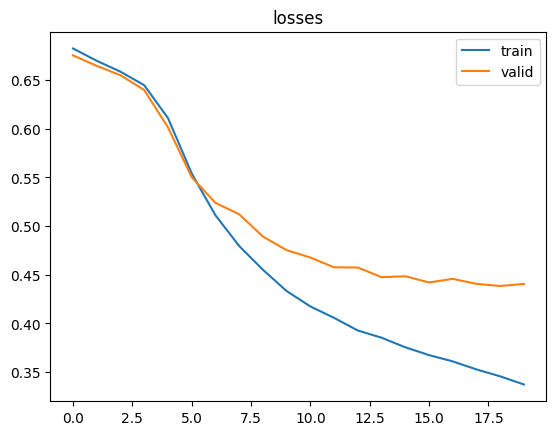

In [ ]:
import matplotlib.pyplot as plt

plt.title("losses")
plt.plot(losses["train_losses"], label="train")
plt.plot(losses["valid_losses"], label="valid")
plt.legend()
plt.show()

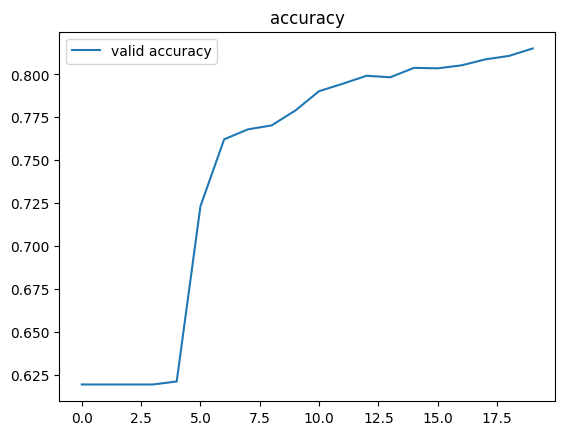

In [ ]:
plt.title("accuracy")
plt.plot(losses["valid_acc"], label="valid accuracy")
plt.legend()
plt.show()

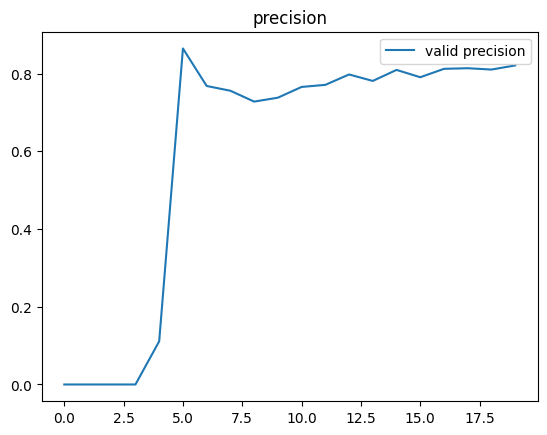

In [ ]:
plt.title("precision")
plt.plot(losses["valid_prec"], label="valid precision")
plt.legend()
plt.show()

In [ ]:
trainer.model = torch.load('best_model.pth')

In [ ]:
test_loss, test_acc, test_prec = trainer.evaluate(test_dataloader)

In [ ]:
print(f"Test loss {test_loss}, Test accuracy: {test_acc}")

Test loss 0.5563119760581425, Test accuracy: 0.7409226196152824


In [ ]:
print(f"Test precision {test_prec}")

Test precision 0.41688315634216583


#OLD CODE

In [ ]:

# class Haspeede3_OLD(Dataset):
#     def __init__(self,input_file: Path,max_length: int = 1028,augmentation:bool = False,device: str = "cuda"):
#         self.data = []
#         #TOKENIZER CHOICE
#         nlp = spacy.load("it_core_news_sm") #TODO forse questo mi rallenta, pensaci!
#         italian_stopwords = spacy.lang.it.stop_words.STOP_WORDS
#         with open(input_file, 'r', encoding='utf-8') as f:
#             for i, line in enumerate(tqdm(f)):
#                 sample = dict()
#                 if augmentation:
#                     sample1 = dict()
#                     sample2 = dict()
#                 element = json.loads(line)
#                 text = element['text']
#                 # text = clean_text(text)
#                 idx = int(element['id'].split('_')[-1])
#                 choices = element['choices']
#                 index_label = int(element['label'])
#                 label = choices[index_label]
#                 label = 0 if (label=='neutrale') else 1
#                 sample["text"] = text
#                 sample["idx"] = idx
#                 #TODO come velocizzare?
#                 #s1: non chiamare la funzione fallo direttamente qua!
#                 tokens = [token.text for token in nlp(text) if token.text.lower() not in italian_stopwords]
#                 if augmentation:
#                     tokens1 = tokens
#                     tokens2 = tokens
#                     sample["label"] = label
#                     sample["tokens"] = tokens
#                     random.shuffle(tokens1)
#                     sample1["tokens"] = tokens1
#                     sample1["label"] = label
#                     random.shuffle(tokens2)
#                     sample2["tokens"] = tokens2
#                     sample2["label"] = label
#                     self.data.append(sample)
#                     self.data.append(sample1)
#                     self.data.append(sample2)
#                 else:
#                     sample["tokens"] = [token.text for token in nlp(text) if token.text.lower() not in italian_stopwords ]
#                     sample["label"] = label
#                     self.data.append(sample)





#         # Keep track of padding id
#         self.padding_id: int | None = None
#         # Initialize indexed data attribute but leave it None
#         # Must be filled through the `.index(vocabulary, label_vocabulary)` method
#         # each dictionary represents a sentence with two keys: "input_ids" and "label"
#         self.indexed_data: list[dict] | None = None

#         # Keep track of the maximum length to allow for a batch
#         self.max_length = max_length

#         # Save device
#         self.device = torch.device(device)




#     def __len__(self) -> int:
#         return len(self.data)

#     def __getitem__(self, idx: int) -> dict:
#         if self.indexed_data is None:
#             raise RuntimeError(
#                 "Trying to retrieve samples but dataset has not been indexed yet!"
#                 + " Be sure to call `.index()` on this object."
#                 + " If you want to retrieve raw elements, call `.get_raw_elements(idx)"
#             )
#         return self.indexed_data[idx]

#     def get_data(self,idx:int) -> dict:
#         if idx < len(self.data):
#             return self.data[idx]

#     def get_vocabulary(self,pad_token:str = "<pad>", unk_token:str = "<unk>", extra_tokens:list[str] = []):
#         vocab_counter = dict(Counter(token for sample in self.data for token in sample["tokens"]).most_common())
#         vocabulary = vocab(vocab_counter, min_freq = 1, specials = [pad_token, unk_token, *extra_tokens])
#         vocabulary.set_default_index(vocabulary([unk_token])[0])
#         return vocabulary

#     def set_padding_id(self,value:int) -> None:
#         self.padding_id = value

#     def index(self, vocabulary:Vocab) -> None:
#         if self.indexed_data is not None:
#             print("Dataset has already been indexed. Keeping old index...")
#         else:
#             indexed_data = []
#             for sample in self.data:
#                 indexed_data.append({"input_ids": vocabulary(sample["tokens"]), "label": sample["label"]})
#             self.indexed_data = indexed_data

#     def get_raw_padding_id(self):
#         return self.padding_id

#     def _collate_fn(self, raw_batch: list[dict]) -> tuple[torch.Tensor,torch.Tensor,torch.Tensor]:
#         if self.padding_id is None:
#             raise RuntimeError("Error: padding not set! Use set_padding_id method!")
#         sequence_lenghts = torch.tensor([len(sample["input_ids"]) for sample in raw_batch], dtype = torch.long)
#         padded_sequence = pad_sequence(
#             (
#                 torch.tensor(sample["input_ids"],dtype = torch.long, device = self.device)
#                 for sample in raw_batch
#             ),
#             batch_first = True,
#             padding_value = self.padding_id
#         )
#         labels = torch.tensor([sample["label"] for sample in raw_batch], device = self.device, dtype=torch.long)
#         return sequence_lenghts,padded_sequence,labels


#     def _collate_fn(self, raw_batch: list[dict]) -> tuple[torch.Tensor,torch.Tensor,torch.Tensor]:
#         if self.padding_id is None:
#             raise RuntimeError("Error: padding not set! Use set_padding_id method!")


#         sequence_lenghts = torch.tensor([len(sample["input_ids"]) for sample in raw_batch], dtype = torch.long)

#         #batch,sentence,word (dimensions)
#         for sentence in raw_batch:
#             for idx,word in enumerate(sentence["input_ids"]):
#                 word = self.model.wv.index_to_key[index]
#                 embedding = self.model.wv[word]
#                 sentence["input_ids"][idx] = embedding




#         padded_sequence = pad_sequence(
#             (
#                 torch.tensor(sample["input_ids"],dtype = torch.long, device = self.device)
#                 for sample in raw_batch
#             ),
#             batch_first = True,
#             padding_value = self.padding_id
#         )
#         labels = torch.tensor([sample["label"] for sample in raw_batch], device = self.device, dtype=torch.long)
#         return sequence_lenghts,padded_sequence,labels










In [ ]:

# data = []
# with open("haspeede3-task1-train-data.jsonl", 'r', encoding='utf-8') as f:
#     for line in f:
#         sample = json.loads(line)
#         data.append(sample)
# # Now the 'data' list contains the data from the .jsonl file

# random.shuffle(data)
# split_index = int(0.90 * len(data))
# train_part = data[:split_index]
# validation_part = data[split_index:]


# test_part = []
# with open("haspeede3-task1-test-data.jsonl", 'r', encoding='utf-8') as f:
#     for line in f:
#         sample = json.loads(line)
#         test_part.append(sample)

# with open('haspeede3-task1-train-PART.jsonl', 'w', encoding='utf-8') as out_file:
#     for index, item in enumerate(train_part):
#         out_file.write(json.dumps(item,ensure_ascii=False))
#         if index < len(train_part) - 1 :
#             out_file.write("\n")  # Write each JSON object on a new line


# with open('haspeede3-task1-validation-PART.jsonl', 'w', encoding='utf-8') as out_file:
#     for index, item in enumerate(validation_part):
#         out_file.write(json.dumps(item,ensure_ascii=False))
#         if index < len(validation_part) - 1:
#              out_file.write("\n")  # Write each JSON object on a new line

In [ ]:
# print(train_dataset.get_vocabulary())
    #{'@unknown': 363, 'Con': 43, 'tutte': 70, 'le': 872, 'denunce': 1, 'che': 3035, 'si': 952, 'sta': 169, 'beccando': 1, ...}
#once most_common was added:
# print(train_dataset.get_vocabulary())
    # {'#': 20161, ',': 4944, '.': 4733, 'di': 3892, 'e': 3192, 'che': 3035, 'il': 2761, 'la': 2286 ... }
#SOME USEFUL FUNCTIONS TO CHECK VOCAB
# print(vocabulary.get_itos()[:10])
# print(vocabulary.get_stoi()[''])